In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install powerlaw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Imports

# plots
import plotly.express as px
import matplotlib.pyplot as plt

# networks
from community import community_louvain
import fa2
import networkx as nx
import powerlaw



import numpy as np
import pandas as pd
from collections import Counter
from collections import defaultdict
import math
import statistics
import re

import csv


import pickle
import os

# imports
import json
import random

import os
from IPython.display import clear_output 
import gc
import itertools

import nltk
from nltk import FreqDist
from collections import defaultdict
from wordcloud import WordCloud

save=False

In [ ]:
spotify_df = pd.read_pickle(r"/content/drive/MyDrive/SocialGraphs/Spotify_data/spotify_dataset_preprocessed.pickle")
# we want `artistname` to be hashable, hence we use a frozenset
spotify_df.artistname = spotify_df.artistname.apply(frozenset)
# some titles contain only numbers, we force everything to be a string
spotify_df["trackname"] = spotify_df.trackname.apply(str)

In [ ]:
spotify_df.head()

user_id        artistname  \
0  9cc0cfd4d7d7885102480dd99e7a90d6  (elvis costello)   
1  9cc0cfd4d7d7885102480dd99e7a90d6  (elvis costello)   
3  9cc0cfd4d7d7885102480dd99e7a90d6  (elvis costello)   
4  9cc0cfd4d7d7885102480dd99e7a90d6  (elvis costello)   
5  9cc0cfd4d7d7885102480dd99e7a90d6          (lissie)   

                                           trackname    playlistname  
0               (The Angels Wanna Wear My) Red Shoes  HARD ROCK 2010  
1  (What's So Funny 'Bout) Peace, Love And Unders...  HARD ROCK 2010  
3                              Accidents Will Happen  HARD ROCK 2010  
4                                             Alison  HARD ROCK 2010  
5                                        All Be Okay  HARD ROCK 2010

In [ ]:
# since multiple tracks can have the same name, it is essential to create a new entry
# in `spotify_df`, where we combine the track's name with the performing artist
spotify_df["tracks"] = list(zip(spotify_df['trackname'], spotify_df['artistname']))


# remove tracks duplicates associated with a user
spotify_df = spotify_df.drop_duplicates(subset=['user_id','tracks'], keep=False)

## Popularity distribution

We define the popularity of a song, artist or genre as the number of users listening to that song, artist or genre. Popularity can be found by counting the occurrences in the dataset.

### Tracks' popularity distribution

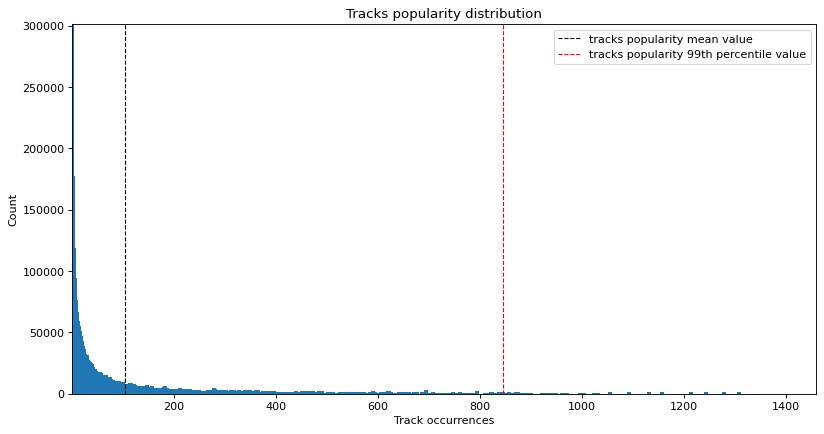

In [ ]:
# Plot tracks frequency distribution
tracks_freq = spotify_df.groupby(['tracks'])['tracks'].transform('count')

hist, bins = np.histogram(tracks_freq, bins=range(min(tracks_freq), max(tracks_freq))) # return an array with histogram values and the bin edges 
track_mean = np.mean(tracks_freq)
track_freq_99h = np.percentile(tracks_freq, 99)

plt.figure(figsize=(12, 6), dpi=80)
# plot histogram
plt.bar(bins[:-1], hist, width = 8)
# draw average value on histogram
plt.axvline(track_mean, color='k', linestyle='dashed', linewidth=1, label='tracks popularity mean value')
# draw 99th percentile value for the tracks popularity distribution:
plt.axvline(track_freq_99h, color='r', linestyle='dashed', linewidth=1, label='tracks popularity 99th percentile value')

plt.title('Tracks popularity distribution')
plt.legend()
plt.xlabel("Track occurrences")
plt.ylabel("Count")
plt.xlim(min(bins[:-1]), max(bins[:-1]))
plt.ylim(0, max(hist))

plt.show()

In [ ]:
print("Tracks popularity mean value is", track_mean)
print("Tracks popularity 99th percentile value is", track_freq_99h)
print("Tracks popularity min value is", np.min(tracks_freq))
print("Tracks popularity max value is", np.max(tracks_freq))

Tracks popularity mean value is 104.36050038277979
Tracks popularity 99th percentile value is 845.0
Tracks popularity min value is 1
Tracks popularity max value is 1462


In [ ]:
# print top 5 tracks
Counter(spotify_df.tracks).most_common(5)

[(('Get Lucky - Radio Edit', frozenset({'daft punk'})), 1462),
 (('Wake Me Up', frozenset({'avicii'})), 1309),
 (('Little Talks', frozenset({'men'})), 1279),
 (('Blurred Lines', frozenset({'robin thicke'})), 1244),
 (('Smells Like Teen Spirit', frozenset({'nirvana'})), 1214)]

In [ ]:
gc.collect()

65

### Artists' popularity distribution

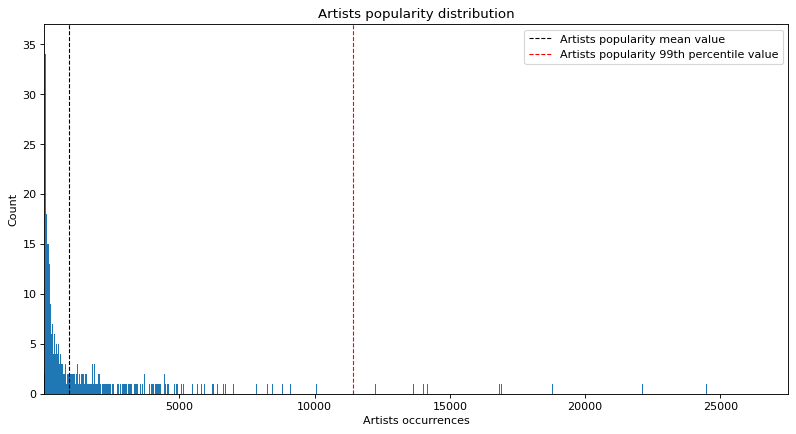

In [ ]:
# Plot artists frequency distribution
artists_freq = list(Counter([artist for artists in spotify_df.artistname for artist in artists]).values())

hist, bins = np.histogram(artists_freq, bins=range(min(artists_freq), max(artists_freq))) # return an array with histogram values and the bin edges 
artists_mean = np.mean(artists_freq)
artists_freq_99h = np.percentile(artists_freq, 99)

plt.figure(figsize=(12, 6), dpi=80)
# plot histogram
plt.bar(bins[:-1], hist, width = 8)
# draw average value on histogram
plt.axvline(artists_mean, color='k', linestyle='dashed', linewidth=1, label='Artists popularity mean value')
# draw 99th percentile value for the tracks popularity distribution:
plt.axvline(artists_freq_99h, color='r', linestyle='dashed', linewidth=1, label='Artists popularity 99th percentile value')

plt.title('Artists popularity distribution')
plt.legend()
plt.xlabel("Artists occurrences")
plt.ylabel("Count")
plt.xlim(min(bins[:-1]), max(bins[:-1]))
plt.ylim(0, max(hist))

plt.show()

In [ ]:
print("Artists popularity mean value is", artists_mean)
print("Artists popularity 99th percentile value is", artists_freq_99h)
print("Artists popularity min value is", np.min(artists_freq))
print("Artists popularity max value is", np.max(artists_freq))

Artists popularity mean value is 931.1050010375596
Artists popularity 99th percentile value is 11410.05999999999
Artists popularity min value is 4
Artists popularity max value is 27517


In [ ]:
# print top 5 artists
Counter([artist for artists in spotify_df.artistname for artist in artists]).most_common(5)

[('daft punk', 27517),
 ('coldplay', 26365),
 ('radiohead', 24490),
 ('the rolling stones', 24057),
 ('david bowie', 23074)]

In [ ]:
# compute inverse frequency for each track
spotify_df['freq'] = spotify_df.groupby(['tracks'])['tracks'].transform('count')
spotify_df = spotify_df[spotify_df.freq > 1]
spotify_df['freq'] = list(map(lambda f: 1/f, spotify_df["freq"]))
spotify_df.head(1)

user_id        artistname  \
0  9cc0cfd4d7d7885102480dd99e7a90d6  (elvis costello)   

                              trackname  \
0  (The Angels Wanna Wear My) Red Shoes   

                                              tracks  \
0  ((The Angels Wanna Wear My) Red Shoes, (elvis ...   

                                               genre      freq  
0  [art rock, folk, folk rock, mellow gold, new w...  0.016667

## Users number of tracks distribution

In [ ]:
# count each users tracks
spotify_df['number_of_tracks'] = spotify_df.groupby(['user_id'])['tracks'].transform('count')

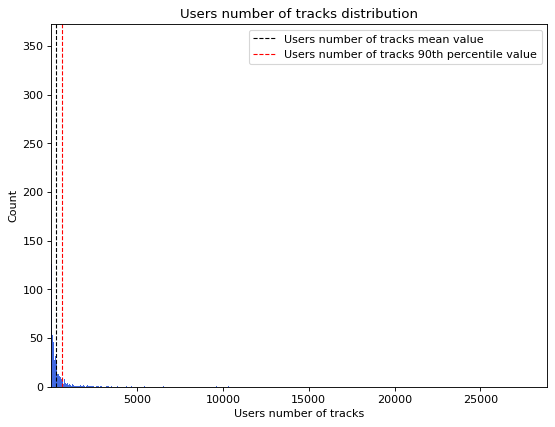

In [ ]:
tracks_number = spotify_df.groupby(['user_id'])['tracks'].agg('count')
hist, bins = np.histogram(tracks_number, bins=range(min(tracks_number), max(tracks_number))) # return an array with histogram values and the bin edges 
tracks_number_mean = np.mean(tracks_number)
tracks_number_90h = np.percentile(tracks_number, 90)

plt.figure(figsize=(8, 6), dpi=80)
# plot histogram
plt.bar(bins[:-1], hist, width = 8, color='royalblue')
# draw average value on histogram
plt.axvline(tracks_number_mean, color='k', linestyle='dashed', linewidth=1, label='Users number of tracks mean value')
# draw 99th percentile value for the tracks popularity distribution:
plt.axvline(tracks_number_90h, color='r', linestyle='dashed', linewidth=1, label='Users number of tracks 90th percentile value')

plt.title('Users number of tracks distribution')
plt.legend()
plt.xlabel("Users number of tracks")
plt.ylabel("Count")
plt.xlim(min(bins[:-1]), max(bins[:-1]))
plt.ylim(0, max(hist))

plt.show()

In [ ]:
print("Users number of tracks mean value is", tracks_number_mean)
print("Users number of tracks 90th percentile value is", tracks_number_90h)
print("Users number of tracks min value is", np.min(tracks_number))
print("Users number of tracks max value is", np.max(tracks_number))

Users number of tracks mean value is 281.4901421366346
Users number of tracks 90th percentile value is 626.0
Users number of tracks min value is 1
Users number of tracks max value is 28906


We expect a very dense network. So, in order to reduce the computational power and ease the analyze and also to keep the true information about the users sample, we eliminate the users which are lisening more that 2000 tracks (since the 99th percentile is 2033, we keep 99% of the information. Moreover, users that are listening more that 2000 don't offer relevant information for the community from which they take part).

In [ ]:
users_cumsum = np.cumsum(np.array(tracks_number)) / sum(np.array(tracks_number))
i_80 = [round(e*100,2) for e in users_cumsum].index(80.01)
i_90 = [round(e*100,2) for e in users_cumsum].index(90.01)

print("Pareto Cumulative Impact:")
print(f"80% cumulative number of tracks frequency obtained with: {i_80} users")
print(f"90% cumulative number of tracks frequency obtained with: {i_90} users")

Pareto Cumulative Impact:
80% cumulative number of tracks frequency obtained with: 12176 users
90% cumulative number of tracks frequency obtained with: 13783 users


In [ ]:
spotify_df = spotify_df[(spotify_df.number_of_tracks < 590)] 
print("Number of user after prefiltering:", len(set(spotify_df.user_id)))

Number of user after prefiltering: 13600


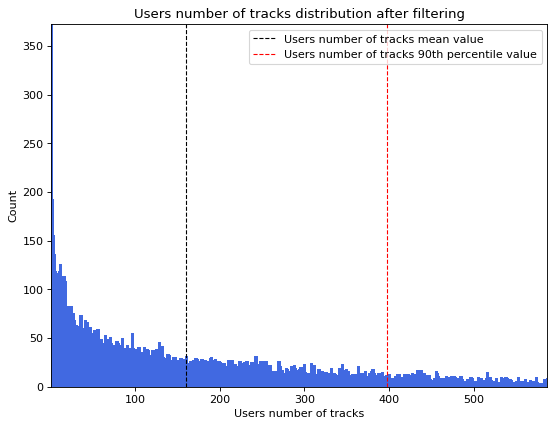

In [ ]:
tracks_number = spotify_df.groupby(['user_id'])['tracks'].agg('count')
hist, bins = np.histogram(tracks_number, bins=range(min(tracks_number), max(tracks_number))) # return an array with histogram values and the bin edges 
tracks_number_mean = np.mean(tracks_number)
tracks_number_90h = np.percentile(tracks_number, 90)

plt.figure(figsize=(8, 6), dpi=80)
# plot histogram
plt.bar(bins[:-1], hist, width = 4, color='royalblue')
# draw average value on histogram
plt.axvline(tracks_number_mean, color='k', linestyle='dashed', linewidth=1, label='Users number of tracks mean value')
# draw 99th percentile value for the tracks popularity distribution:
plt.axvline(tracks_number_90h, color='r', linestyle='dashed', linewidth=1, label='Users number of tracks 90th percentile value')

plt.title('Users number of tracks distribution after filtering')
plt.legend()
plt.xlabel("Users number of tracks")
plt.ylabel("Count")
plt.xlim(min(bins[:-1]), max(bins[:-1]))
plt.ylim(0, max(hist))

plt.show()

In order to create the users' network, we need to discover the connections between the users. Hence, we construct a `users_df`, where the users who are listening to the same song are grouped in a list.

In [ ]:
# users dataframe
users_df = spotify_df.groupby(['tracks', 'freq'])['user_id'].apply(list).reset_index()

Once the users are grouped, we can create a data frame with edges. Given the list of users, `[A, B, C]`,  where users are listening to a particular song which has the frequency `f`, we create a link between each of the three users weighted with `f`, `A-B`, `A-C` and `B-C`. The final `users_df` will have three columns **source**, **target** and **weight**, and will be use to generate the users' network. 

In [ ]:
users_edges = list(map(lambda users, freq: [(users[i], users[j], freq) for i in range(0, len(users) - 1) for j in range(i + 1, len(users))],\
                       users_df.user_id, users_df.freq))
users_edges = [j for i in users_edges for j in i]

users_df = pd.DataFrame( \
           users_edges,\
           columns =['source', 'target', 'weight'])

# if two users have multiple tracks in common, aggregate the weight of each track
users_df = users_df.groupby(['source', 'target'])['weight'].agg(np.sum).reset_index()
users_df.head()

source                            target  \
0  00055176fea33f6e027cd3302289378b  000c11a16c89aa4b14b328080f5954ee   
1  00055176fea33f6e027cd3302289378b  00b4539e695290d981811f448e6df4ea   
2  00055176fea33f6e027cd3302289378b  00b79debf87ef0364017de90836dc35e   
3  00055176fea33f6e027cd3302289378b  00c58a505e97067cf582e2cfac4e3a04   
4  00055176fea33f6e027cd3302289378b  00d00aec0d2d486af2d8dd4816574066   

     weight  
0  0.006690  
1  0.030556  
2  0.003717  
3  0.004254  
4  0.005405

In [ ]:
del users_edges
gc.collect()

44597160

## Creating Users Network

In [ ]:
users_graph = nx.from_pandas_edgelist(
    users_df,
    edge_attr=["weight"],
    create_using=nx.Graph(),
)

In [ ]:
# delete users_df to free memory since all needed information is in `users_graph`
del users_df
gc.collect()

21

In [ ]:
# save network as edge list
from networkx.readwrite import json_graph
with open("./users_graph.json", "w") as outfile:
    outfile.write(json.dumps(json_graph.node_link_data(users_graph)))

NameError: ignored

In [ ]:
print("Number of nodes:",len(users_graph.nodes()))
print("Number of edges:", len(users_graph.edges()))
print(f"Graph Density: {round(nx.density(users_graph)*100,2)}%")

Even if we reduced the number of nodes by filtering the users that are listening vast amount of tracks (a number higher than the number of songs that are listening by 90% of users), the network is still very dense to be analyzed by a regular computer. To solve this drawback, we have to extract the backbone. 

To extract the backbone we use the `disparity filter` approch, which have been discuss in [Extracting the multiscale backbone of complex weighted networks](https://https://www.pnas.org/doi/epdf/10.1073/pnas.0808904106). The disparity filter is a way to identify which links, or connections, in a network should be preserved by using a null model. [TODO: explain more]

The implementation of the disparity filter, which can be found in the `disparity_filter.py` script, was borrowed from [aekpalakorn/python-backbone-network](https://github.com/aekpalakorn/python-backbone-network).

In [ ]:
from disparity_filter import disparity_filter

alpha = 0.05
users_graph = disparity_filter(users_graph)
users_graph = nx.Graph([(u, v, d) for u, v, d in users_graph.edges(data=True) if d['alpha'] < alpha])

print('backbone: nodes = %s, edges = %s' % (users_graph.number_of_nodes(), users_graph.number_of_edges()))
print(users_graph.edges(data=True))


In [ ]:
# save network as edge list
from networkx.readwrite import json_graph
with open("./users_graph_backbone.json", "w") as outfile:
    outfile.write(json.dumps(json_graph.node_link_data(users_graph)))

In [ ]:
from networkx.readwrite import json_graph
with open("/content/drive/MyDrive/SocialGraphs/Spotify_data/users_graph_backbone.json", "r") as f:
    js_graph = json.load(f)
users_graph = json_graph.node_link_graph(js_graph)

In [ ]:
print("Number of nodes:",len(users_graph.nodes()))
print("Number of edges:", len(users_graph.edges()))
print(f"Graph Density: {round(nx.density(users_graph)*100,2)}%")

Number of nodes: 13130
Number of edges: 1791938
Graph Density: 2.08%


Our final users network consists of 13,130 nodes and 1,791,938 edges, where the graph density has been reduced to 2.08%, making the graph easy to analyze.

## Users network analysis

### Degree distribution

We start our discussion about the users network by analyzing the degree distribution, since the degree can quantify the amount of interaction which a user has with other users.

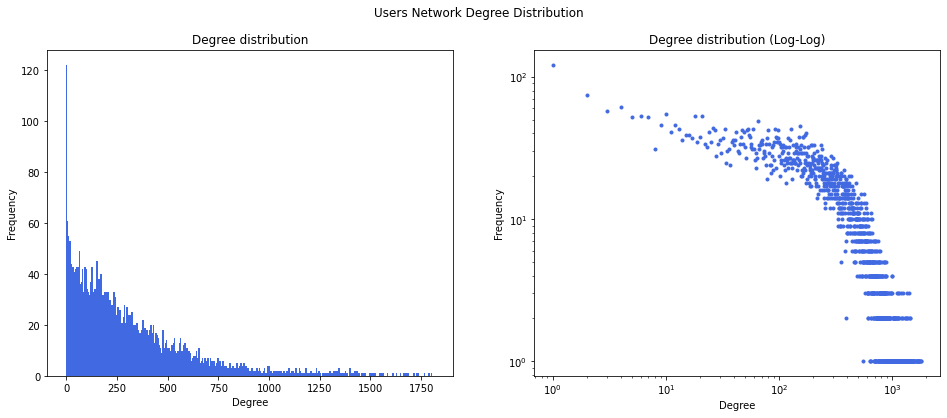

In [ ]:
# Plot degree distribution
users_graph_degree = dict(sorted(dict(users_graph.degree()).items()))
users_graph_degree_seq = list(users_graph_degree.values())
hist, bins = np.histogram(users_graph_degree_seq, bins=range(min(users_graph_degree_seq), max(users_graph_degree_seq)))

fig, ax = plt.subplots(1,2, figsize=(16,6))
fig.suptitle("Users Network Degree Distribution")
ax[0].bar(bins[:-1], hist, width = 8, color='royalblue')
ax[0].set_xlabel("Degree")
ax[0].set_ylabel("Frequency")
ax[0].set_title("Degree distribution")

ax[1].loglog(bins[:-1], hist,'.', color='royalblue')
ax[1].set_xlabel('Degree')
ax[1].set_ylabel("Frequency")
ax[1].set_title("Degree distribution (Log-Log)")


plt.show()

In [ ]:
print('Average:', round(np.mean(users_graph_degree_seq),3))
print('Median:', np.median(users_graph_degree_seq))
print('Mode:', statistics.mode(users_graph_degree_seq))
print('Max:', max(users_graph_degree_seq))
print('Min:', min(users_graph_degree_seq))

Average: 272.953
Median: 207.0
Mode: 1
Max: 1814
Min: 1


A median with a low value compared to the maximum degree of a network and a mode value equal to 1 may indicate a distribution which follows the power law. Moreover, the exponential decay can be seen slightly in the logarithmic plot. Nonetheless, the scatter points do not form a straight line due to a small number of large hubs.

We are interested to see the value for the exponent degree $\gamma$. To get a approximation for $\gamma$, we fit the network degree distribution:

In [ ]:
gamma = powerlaw.Fit(users_graph_degree).alpha
print("Degree exponent:", round(gamma,3))

Calculating best minimal value for power law fit
Degree exponent: 4.413


In Chapter 4 of [NETWORK SCIENCE by ALBERT-LÁSZLÓ BARABÁSI](http://networksciencebook.com/chapter/4#ultra-small) are defined four region based on the value of the degree exponent.

In our case, the degree exponent $\gamma$ is equal with 4.413 which means that the users network follows the **small world**'s rules. In this regime, the hubs continue to be present, but they are not large or numerous enough to have a significant impact on the distance between nodes.

We expect users with a large number of connections to listen to a large number of songs (there is a higher probability for them to have more in common with other users if they are listening to more tracks). To test this hypothesis, we calculate the correlation between the degree and the number of pieces a user has.

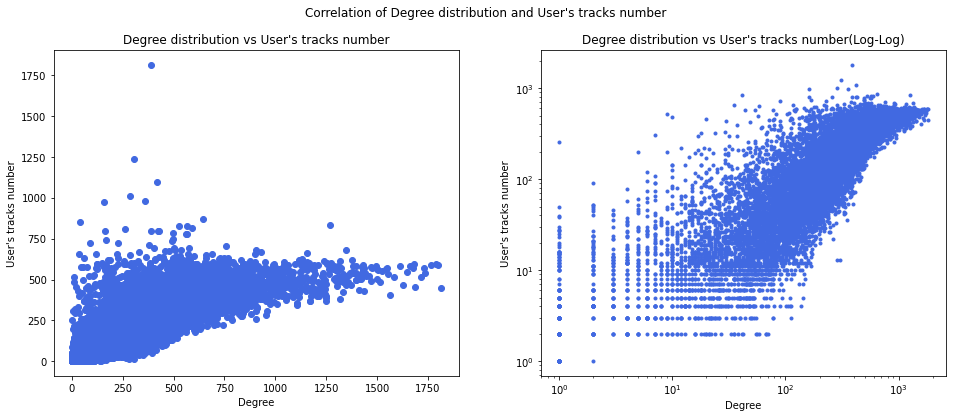

In [ ]:
# Plot degree distribution vs user's tracks number
users_tracks_no = spotify_df[spotify_df.user_id.isin(users_graph_degree.keys())].groupby(['user_id'])['tracks'].agg('count').to_dict()
users_tracks_no = dict(sorted(users_tracks_no.items()))
users_tracks_no_seq = list(users_tracks_no.values())

fig, ax = plt.subplots(1,2, figsize=(16,6))
fig.suptitle("Correlation of Degree distribution and User's tracks number")
ax[0].scatter(users_graph_degree_seq, users_tracks_no_seq, color='royalblue')
ax[0].set_xlabel("Degree")
ax[0].set_ylabel("User's tracks number")
ax[0].set_title("Degree distribution vs User's tracks number")

ax[1].loglog(users_graph_degree_seq, users_tracks_no_seq,'.', color='royalblue')
ax[1].set_xlabel('Degree')
ax[1].set_ylabel("User's tracks number")
ax[1].set_title("Degree distribution vs User's tracks number(Log-Log)")

plt.show()

In [ ]:
print("Correlation of Degree distribution and User's tracks number:", round(np.corrcoef(users_graph_degree_seq, users_tracks_no_seq)[0,1],2))

Correlation of Degree distribution and User's tracks number: 0.8


Analyzing the plot, on both scales, linear and logarithmic, we can notice that the number of tracks that a user is listening to is correlated with the user's degree. Moreover, the Pearson product-moment correlation coefficient indicates a strong correlation of 0.8.

### Users network communities

One of our goals is to decide whether the music we listen to places us in a certain category. To conclude this hypothesis, it is essential to analyze the communities formed within the user's network. To compute the users communities we used the [Louvain Community Detection Algorithm](https://python-louvain.readthedocs.io/en/latest/api.html), which compute the partition of the graph nodes which maximises the modularity using the Louvain heuristices.

In [ ]:
%%time
from community import community_louvain
# compute the best partition
communities = community_louvain.best_partition(users_graph, random_state=0) 
# we used random_state parameter so that the results can be reproduced
mod = community_louvain.modularity(communities, users_graph)
print("modularity is", mod)

modularity is 0.31175317923443946
CPU times: user 3min 32s, sys: 1.4 s, total: 3min 34s
Wall time: 3min 34s


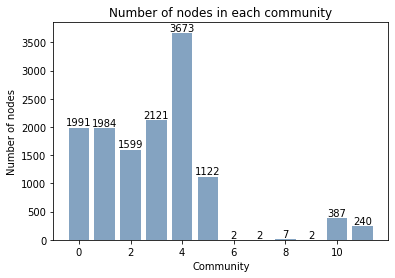

In [ ]:
_commnodes = list(Counter(communities.values()).values())
_comm = list(Counter(communities.values()).keys())
fig, ax = plt.subplots()

p = ax.bar(_comm, _commnodes, color=(0.2, 0.4, 0.6, 0.6))

ax.axhline(0, color='grey', linewidth=0.8)
ax.set_ylabel('Number of nodes')
ax.set_xlabel('Community')
ax.set_title('Number of nodes in each community')
ax.bar_label(p)

plt.show()

The algorithm detects 12 communities, half of which have more than 1000 nodes. Interestingly, four communities have less than ten nodes, which makes these users isolated to some extend from the entire network. However, the modularity is equal to 0.311, indicating good partitioning.

In [ ]:
%%time
# split nodes in communities
comm_split = defaultdict(list)
for key, val in sorted(communities.items()):
    comm_split[val].append(key)
comm_split = dict(sorted(comm_split.items()))

CPU times: user 29.3 ms, sys: 0 ns, total: 29.3 ms
Wall time: 31.7 ms


In [ ]:
!pip install matplotlib --upgrade

In [ ]:
import fa2

forceatlas2 = fa2.ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        edgeWeightInfluence=0.0,

                        # Performance
                        jitterTolerance=0.9,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,

                        # Tuning
                        scalingRatio=0.9,
                        strongGravityMode=True,
                        gravity=0.9,

                        # Log
                        verbose=True)
positions = forceatlas2.forceatlas2_networkx_layout(users_graph, pos=None, iterations=2000)
        
plt.figure(figsize=(12, 10), dpi=80)

communities_color = {} # keep a dict with colors for each community

for community in  Counter(communities.values()):
    communities_color[community] = np.array([random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)])
    nodelist = []
    
    for node in users_graph:
        if communities[node] == community:
            nodelist.append(node)
    # display nodes from current Marvel's community       
    nx.draw_networkx_nodes(users_graph,
                           pos=positions,
                           nodelist=nodelist,
                           node_size=np.array(list(dict(users_graph.degree(nodelist)).values())) / 50,
                           node_color=communities_color[community].reshape(1,-1), label=community)
nx.draw_networkx_edges(users_graph, pos=positions, alpha=0.01, edge_color=(0.7, 0.7, 0.7))
plt.legend()


### Clustering coefficient

According to the [NETWORK SCIENCE by ALBERT-LÁSZLÓ BARABÁSI](http://networksciencebook.com/chapter/2#clustering) the clustering coefficient captures the degree to which the neighbors of a given node link to each other. It is an essential measure for our user network, as we intend to know whether not only the user is connected to another user but also their neighbours. In other words, if a user's neighbours also share the same tracks and music tastes.

The clustering coefficient is a value between 0 and 1, where if the clustering coefficient is 0, none of the neighbors of node link to each other, and if the clustering coefficient is 1, all the neighbors link to each other.

In [ ]:
%%time
cc = nx.clustering(users_graph)
cc_values = list(cc.values()) 

CPU times: user 6min 40s, sys: 929 ms, total: 6min 41s
Wall time: 6min 52s


In [ ]:
avg_cc = np.mean(cc_values)
n_cc0 = len(list(filter(lambda n: n == 0, cc_values)))
n_cc1 = len(list(filter(lambda n: n == 1, cc_values)))

print("Average clustering coefficient:", round(avg_cc, 3))
print("Nodes with clustering coefficient 0:", n_cc0)
print("Nodes with clustering coefficient 1:", n_cc1)

Average clustering coefficient: 0.225
Nodes with clustering coefficient 0: 155
Nodes with clustering coefficient 1: 183


In the users network only 155 nodes have the clustering coeficient equal with 0, which represents 0.011. Similar, the percentage of nodes with a maximum value for clustering coefficint is only 0.014. 

The average clustering coefficient has a relatively low value, only 22.5%. Since the clustering coefficient has been computed at the level of the entire network and we have seen that our networks consist of 12 relatively well-modular partitions, the border nodes which interconnect the communities may diminish the coefficient. In this case is necessary to compute the clustering coefficient for each community.

In [ ]:
# clustering coefficient for each community:
cc_comm = {}
for key, values in comm_split.items():
    cc_comm[key] = list(nx.clustering(users_graph.subgraph(values)).values())
cc_comm = dict(sorted(cc_comm.items()))

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


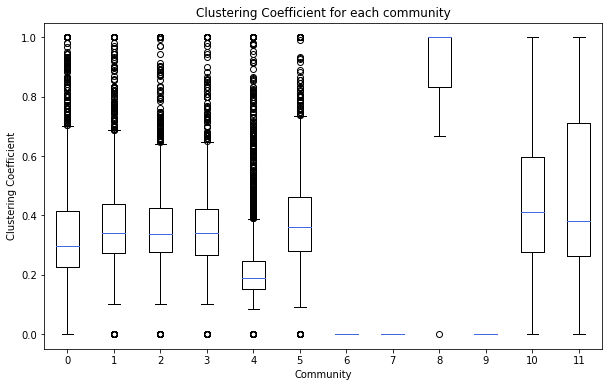

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax.boxplot(cc_comm.values(),
           medianprops=dict(color='royalblue'))

ax.set_xticklabels(cc_comm.keys())
ax.set_ylabel('Clustering Coefficient')
ax.set_xlabel('Community')
ax.set_title('Clustering Coefficient for each community')

plt.show()

It should be noted that for communities 6, 7 and 9 the clustering coefficient is 0 due to the small number of nodes, only two, and should be ignored from this discussion.

In majority of the communities the median of clustring coefficient is higher that 0.3. The median value of the community 4 has a value lower than 0.2, which might indicate a weak linkage between users and therefore, a tendency to listen slightly different kinds of music. 

Visualizing the box-plot of each community, we undertand in the network exist  users with strong linkage, which may indicate that that people who share similar music tastes tend to be friends with each other.



#### Correlation of Clustering Coefficient vs. Degree

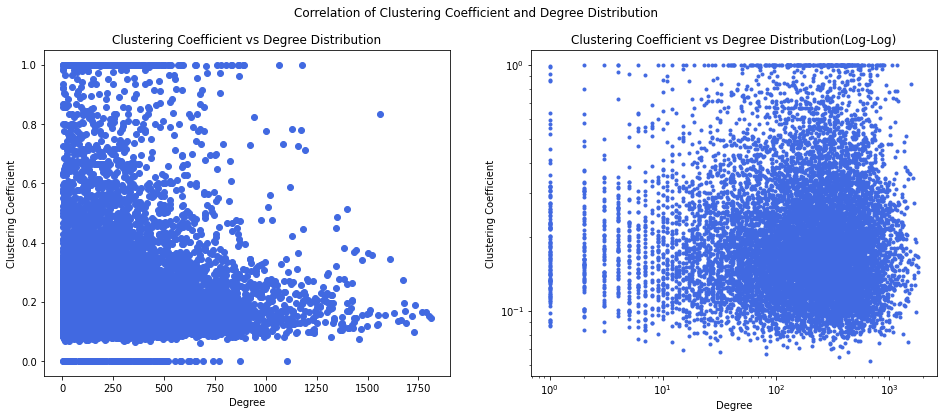

In [ ]:
# Plot clustering coefficient vs degree distribution

fig, ax = plt.subplots(1,2, figsize=(16,6))
fig.suptitle("Correlation of Clustering Coefficient and Degree Distribution")
ax[0].scatter(users_graph_degree_seq, cc_values, color='royalblue')
ax[0].set_xlabel("Degree")
ax[0].set_ylabel("Clustering Coefficient")
ax[0].set_title("Clustering Coefficient vs Degree Distribution")

ax[1].loglog(users_graph_degree_seq, cc_values,'.', color='royalblue')
ax[1].set_xlabel('Degree')
ax[1].set_ylabel("Clustering Coefficient")
ax[1].set_title("Clustering Coefficient vs Degree Distribution(Log-Log)")

plt.show()

In [ ]:
print("Correlation of Clustering Coefficient and Degree Distribution:", round(np.corrcoef(users_graph_degree_seq, cc_values)[0,1],2))

Correlation of Clustering Coefficient and Degree Distribution: -0.01


Both the two plots and the Pearson coefficient indicate the lack of a correlation between the two variables.

### Centrality

In [ ]:
%%time
# get degree centrality
ec = nx.eigenvector_centrality(users_graph)
ec = dict(sorted(ec.items()))

CPU times: user 22.2 s, sys: 63.9 ms, total: 22.3 s
Wall time: 25.3 s


In [ ]:
%%time
# eigenvector centrality for each community:
ec_comm = {}
for key, values in comm_split.items():
    ec_comm[key] = list(nx.eigenvector_centrality(users_graph.subgraph(values)).values())
ec_comm = dict(sorted(ec_comm.items()))

CPU times: user 34.8 s, sys: 89.5 ms, total: 34.9 s
Wall time: 35 s


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


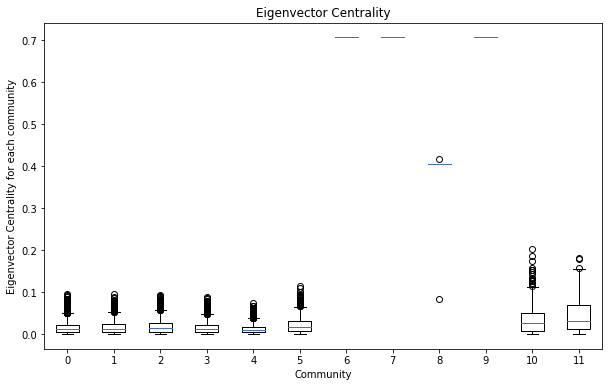

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

ax.boxplot(ec_comm.values(),medianprops=dict(color='royalblue'))
ax.set_xticklabels(ec_comm.keys())
ax.set_ylabel('Eigenvector Centrality for each community')
ax.set_xlabel('Community')
ax.set_title('Eigenvector Centrality')

plt.show()

#### Correlation of Centrality and Degree distribution

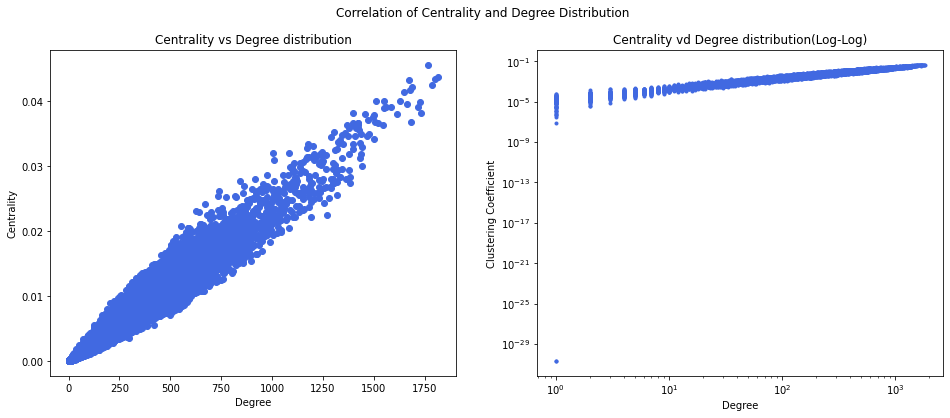

In [ ]:
# Plot Centrality and Degree distribution

fig, ax = plt.subplots(1,2, figsize=(16,6))
fig.suptitle("Correlation of Centrality and Degree Distribution")
ax[0].scatter(users_graph_degree_seq, ec.values(), color='royalblue')
ax[0].set_xlabel("Degree")
ax[0].set_ylabel("Centrality")
ax[0].set_title("Centrality vs Degree distribution")

ax[1].loglog(users_graph_degree_seq, list(ec.values()),'.', color='royalblue')
ax[1].set_xlabel('Degree')
ax[1].set_ylabel("Clustering Coefficient")
ax[1].set_title("Centrality vd Degree distribution(Log-Log)")

plt.show()

In [ ]:
print("Correlation of Centrality and Degree:", round(np.corrcoef(users_graph_degree_seq, list(ec.values()))[0,1],2))

Correlation of Centrality and Degree: 0.97



Correlation of Centrality and User's tracks number

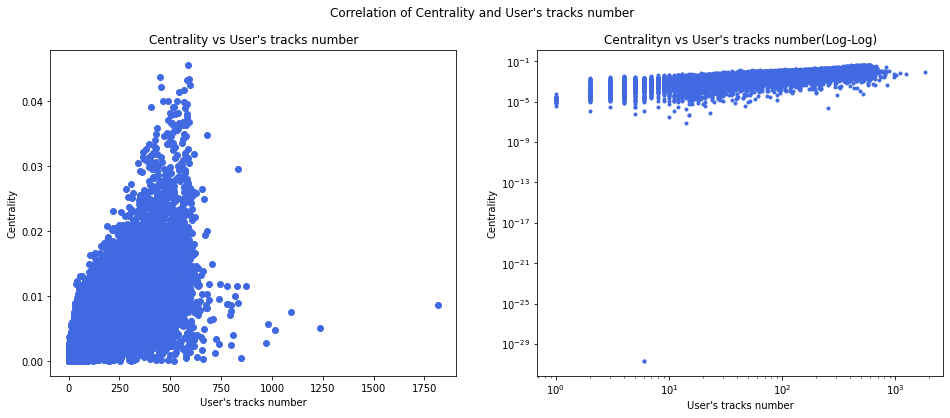

In [ ]:
# Plot Centrality and User's tracks number

fig, ax = plt.subplots(1,2, figsize=(16,6))
fig.suptitle("Correlation of Centrality and User's tracks number")
ax[0].scatter(users_tracks_no_seq, ec.values(), color='royalblue')
ax[0].set_xlabel("User's tracks number")
ax[0].set_ylabel("Centrality")
ax[0].set_title("Centrality vs User's tracks number")

ax[1].loglog(users_tracks_no_seq, list(ec.values()), '.', color='royalblue')
ax[1].set_xlabel("User's tracks number")
ax[1].set_ylabel('Centrality')
ax[1].set_title("Centralityn vs User's tracks number(Log-Log)")

plt.show()

In [ ]:
print("Correlation of Centrality and Number of tracks:", round(np.corrcoef(users_tracks_no_seq, list(ec.values()))[0,1],2))

Correlation of Centrality and Number of tracks: 0.7


Percentage of a user's tracks that are also listened to by other users in the same community

We are interseted to discover how many of the user's tracks are listening by other users from the same community.

In [ ]:
%%time
# compute the % of a user's tracks that are also listened to by other users in the same community.
comm_tracks_per = defaultdict(list)
for key, users in comm_split.items():
    tracks = Counter(spotify_df[spotify_df.user_id.isin(users)].tracks)

    i = 0
    for u in users:
        if i % 10 == 0:
            clear_output()
            print(key)
            print(i, "/", len(users))
        i+=1
        
        u_tracks = Counter(spotify_df[spotify_df.user_id == u].tracks)

        diff = tracks - u_tracks
        p = len(set(u_tracks) & set(diff)) / len(set(u_tracks))
        comm_tracks_per[key].append(p)
        
comm_tracks_per = dict(sorted(comm_tracks_per.items()))
# with open('/content/drive/MyDrive/SocialGraphs/Spotify_data/comm_tracks_per.pkl', 'wb') as f:
#     pickle.dump(comm_tracks_per, f)

9
0 / 2
CPU times: user 1h 33min 12s, sys: 25.6 s, total: 1h 33min 37s
Wall time: 1h 34min 37s


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


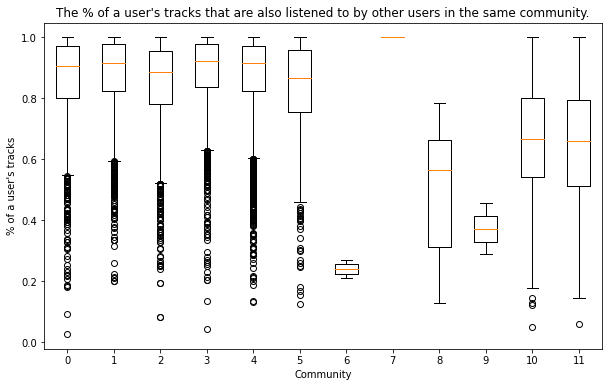

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

ax.boxplot(comm_tracks_per.values())
ax.set_xticklabels(comm_tracks_per.keys())
ax.set_ylabel("% of a user's tracks")
ax.set_xlabel('Community')
ax.set_title("The % of a user's tracks that are also listened to by other users in the same community.")

plt.show()

The box-plot depicts an expacted behaviour, a trementour percentage of the tracks that a user is listening to are also listened by other users from the same community. 

#### Dominant artists in community:

In [ ]:
_comm_artists = defaultdict(list)
for key, users in comm_split.items():
    _comm_artists[key] += [a for artist in spotify_df[spotify_df.user_id.isin(users)].artistname for a in artist]

In [ ]:
TF_gen = {}
for key, value in _comm_artists.items():
    word_list = list(value)
    print(word_list[0])
    break
    TF_gen[key] = FreqDist(word_list)

rascal flatts


In [ ]:
# Plot
def plot_word_cloud(document, title):
    wc = WordCloud(
            background_color="white", 
            max_words=4000, contour_width=3, 
            contour_color='steelblue', 
            collocations=False
        ).generate(document)

    plt.figure(figsize=[8,4])
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

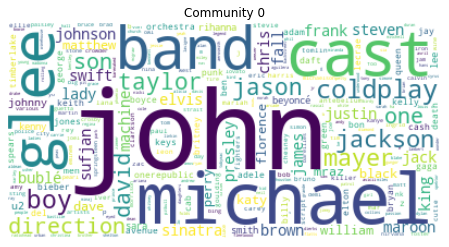

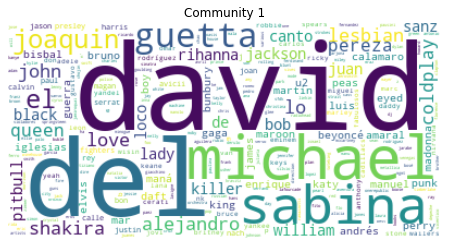

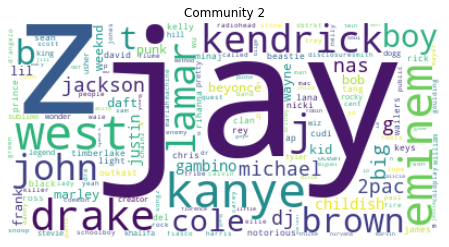

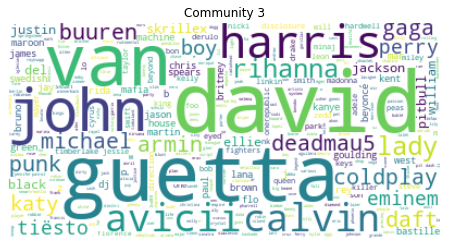

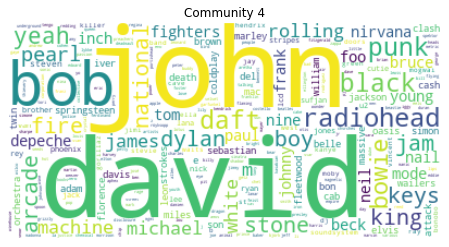

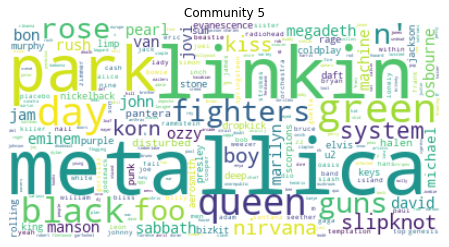

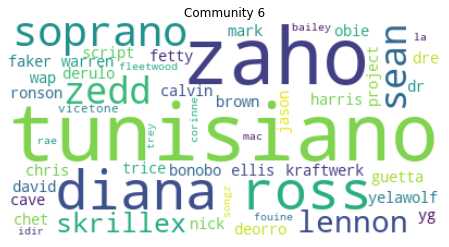

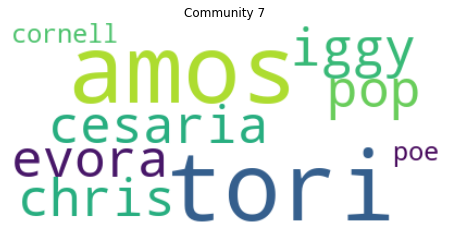

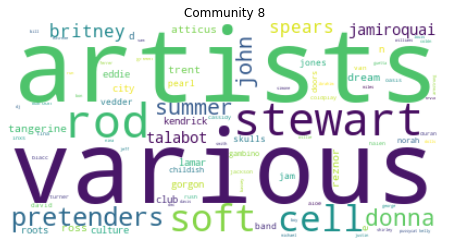

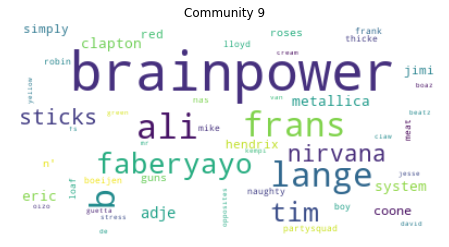

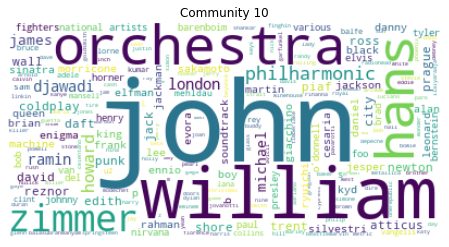

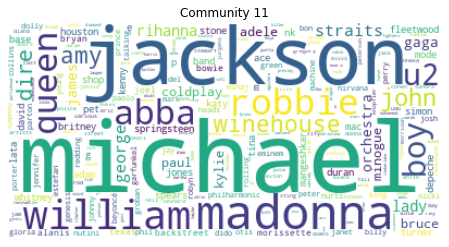

In [ ]:
# Create a WordCloud for each comunity
for (key, tfidf_doc) in TF_gen.items():
    doc_words = " ".join([(w + " ") * int(n) for w, n in Counter(tfidf_doc).most_common()])
    plot_word_cloud(doc_words, "Community " + str(key))

In [ ]:
def computeTF(bag_of_words):
    """
        Get frequency of each word in each document
    """
    return dict([(key, Counter(value)) for key, value in bag_of_words.items()])

def computeIDF(document_words_freq):
    N = len(document_words_freq)
    
    idf_dict = {}
    for document in document_words_freq.values():
        for word, val in document.items():
            if val > 0:
                if word in idf_dict:
                    idf_dict[word] += 1
                else:
                    idf_dict[word] = 1
    
    for word, val in idf_dict.items():
        idf_dict[word] = math.log(N / val)
    return idf_dict

def computeTFIDF(tfs, idfs):
    tfidf = {}
    for word, val in tfs.items():
        tfidf[word] = val * idfs[word]
    return tfidf

In [ ]:
document_tf = computeTF(_comm_artists)

In [ ]:
word_idf = computeIDF(document_tf)

In [ ]:
document_tfidf = dict([(key, computeTFIDF(document_tf[key], word_idf)) for key in _comm_artists.keys()])

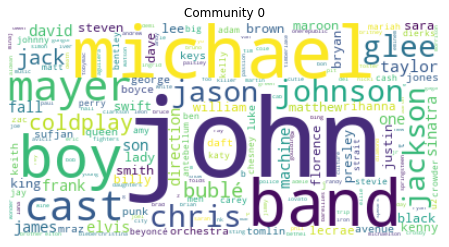

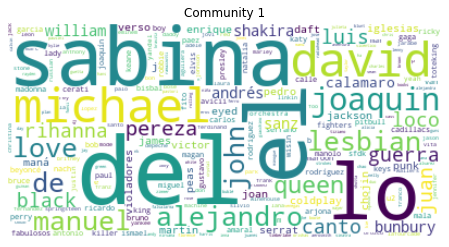

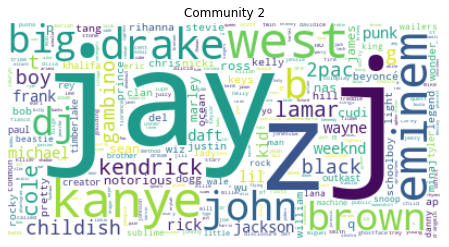

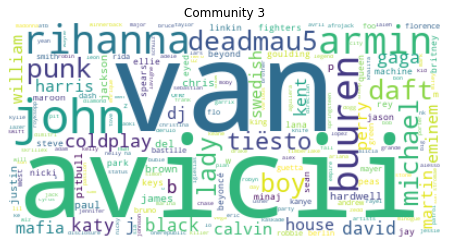

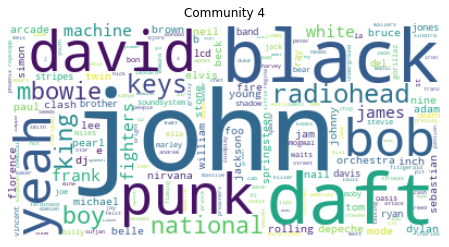

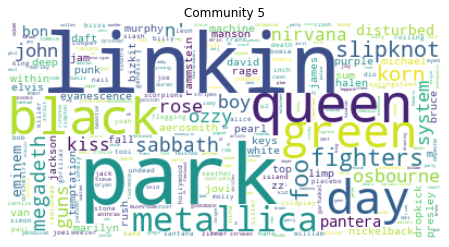

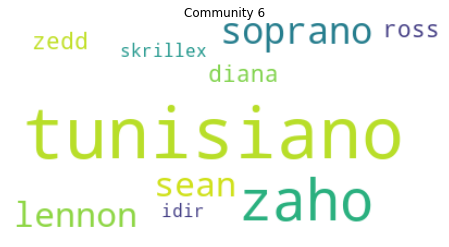

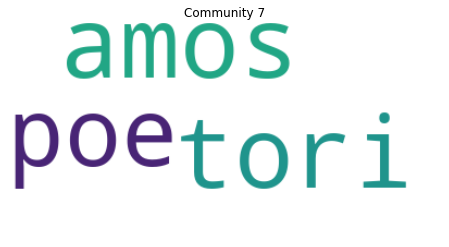

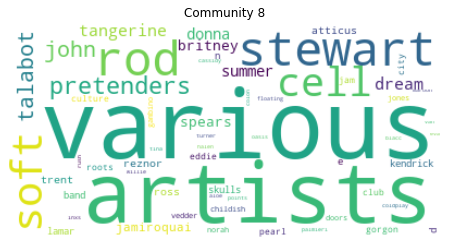

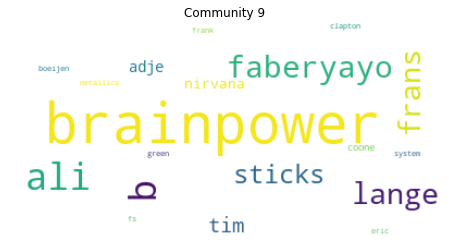

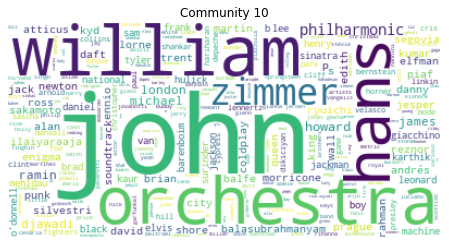

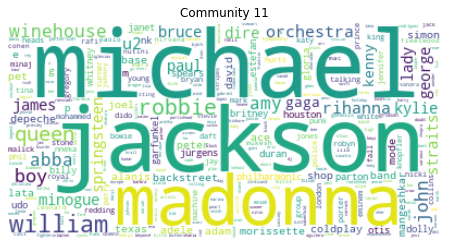

In [ ]:
# Create a WordCloud for each comunity
for (key, tfidf_doc) in document_tfidf.items():
    doc_words = " ".join([(w + " ") * int(n) for w, n in Counter(tfidf_doc).most_common()])
    plot_word_cloud(doc_words, "Community " + str(key))

### Dominant genres in communities

In [ ]:
_comm_genres = defaultdict(list)
for key, users in comm_split.items():
    _comm_genres[key] += [g for genre in spotify_df[spotify_df.user_id.isin(users)].genre for g in genre]

In [ ]:
TF_gen = {}
for key, value in _comm_genres.items():
    word_list = list(value)
    TF_gen[key] = FreqDist(word_list)

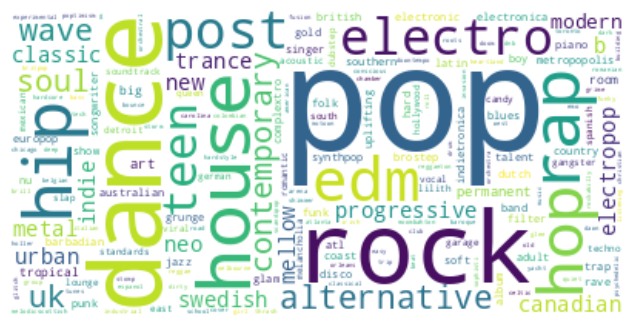

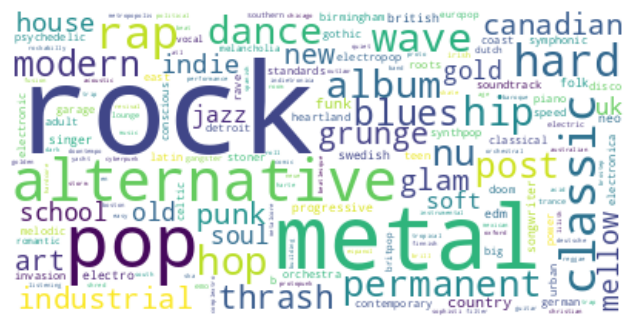

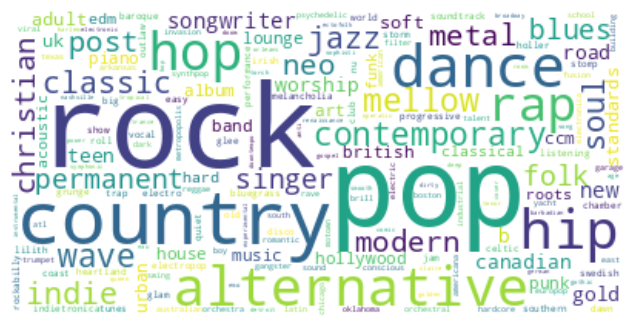

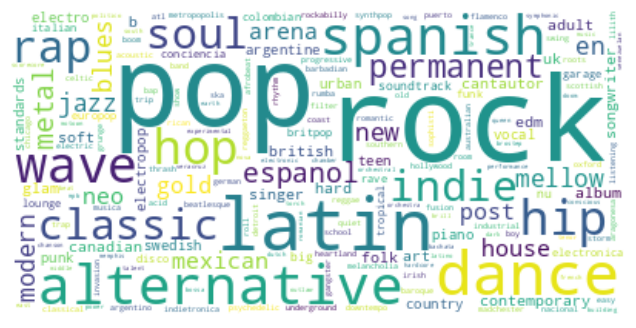

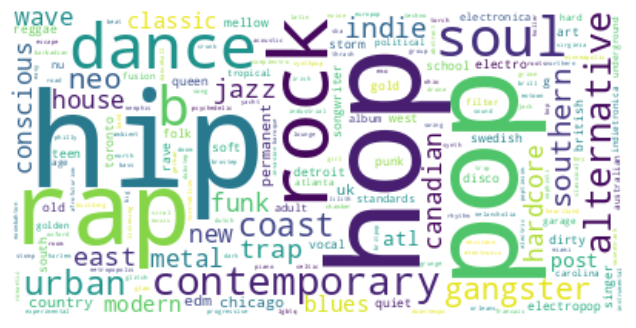

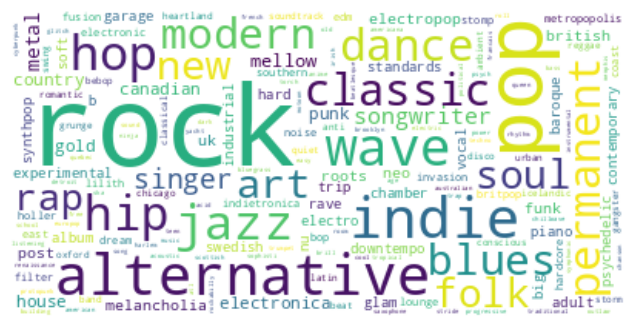

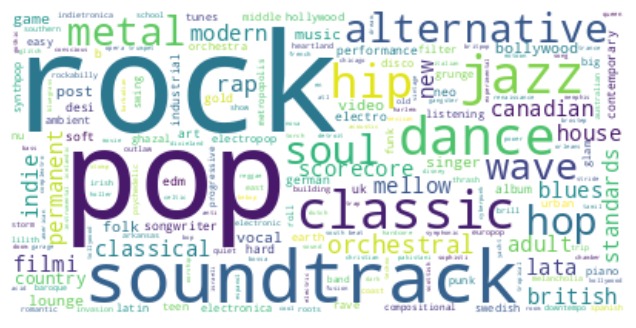

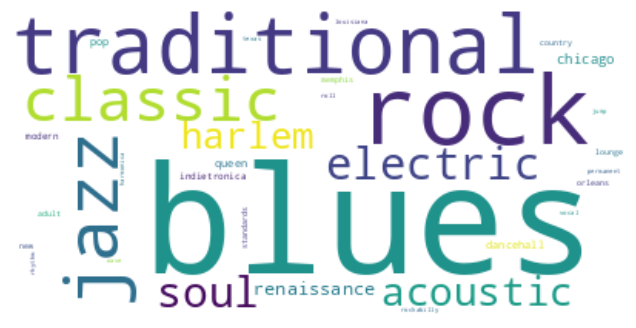

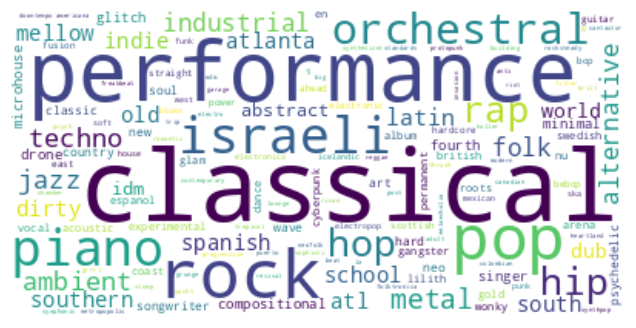

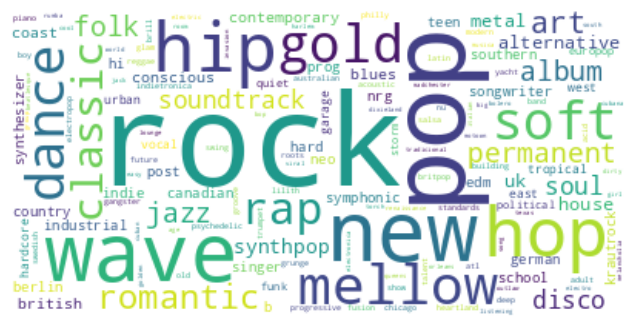

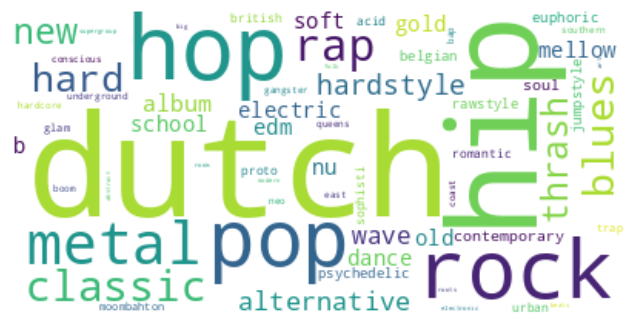

In [ ]:
# Create a WordCloud for each comunity
for (key, tfidf_doc) in TF_gen.items():
    doc_words = " ".join([(w + " ") * int(n) for w, n in Counter(tfidf_doc).most_common()])
    plot_word_cloud(doc_words, "Community " + str(key))

### Lyrics words cloud based on users communities